<a href="https://colab.research.google.com/github/fawaaazi/test/blob/main/BERT_Confusion_Matrix_on_IMDb_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Before running, make sure to install the required libraries:
# pip install transformers datasets scikit-learn matplotlib seaborn torch

import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np






In [ ]:
# --- 1. Load and Prepare the Dataset ---
print("Loading and preparing the IMDb dataset...")

# Load the IMDb dataset. We'll use a small subset for this example to run quickly.
# The `train` split is used for both training and validation, and `test` is for final evaluation.
dataset = load_dataset("imdb")

# To make this example fast, we'll only use a small fraction of the data.
# In a real-world scenario, you would use the full dataset.
train_subset = dataset["train"].shuffle(seed=42).select(range(100))
test_subset = dataset["test"].shuffle(seed=42).select(range(200))

# The dataset is pre-labeled with 'label': 0 (negative) and 1 (positive).

# --- 2. Tokenize the Data ---
print("Tokenizing the data for BERT...")

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading and preparing the IMDb dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizing the data for BERT...


In [ ]:
def tokenize_function(examples):
    # This function tokenizes the text and returns a dictionary of inputs for the model.
    # The padding and truncation ensure that all sequences have the same length.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenizer to the training and testing subsets
tokenized_train_subset = train_subset.map(tokenize_function, batched=True)
tokenized_test_subset = test_subset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors and specify the columns needed for the model
tokenized_train_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# --- 3. Fine-tune the BERT Model ---
print("Fine-tuning the BERT model...")

# Load the pre-trained BERT model for sequence classification.
# The number of labels is set to 2 (positive and negative).
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments. These control the fine-tuning process.
# This setup is optimized for a quick example.
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=1,  # A single epoch for demonstration.
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=100,
# )

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
)


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Fine-tuning the BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize the Trainer object.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_subset,
)

# Initialize the Trainer object.
# The Trainer handles the training loop, evaluation, and logging.
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_subset,
# )

# # Start the fine-tuning process. This may take a few minutes.
# trainer.train()

# --- 4. Make Predictions and Generate the Confusion Matrix ---
print("Making predictions and generating the confusion matrix...")

# Disable gradients for prediction to save memory and speed up computation.
with torch.no_grad():
    # Make predictions on the test dataset
    predictions = trainer.predict(tokenized_test_subset)



Making predictions and generating the confusion matrix...


Visualizing the confusion matrix...


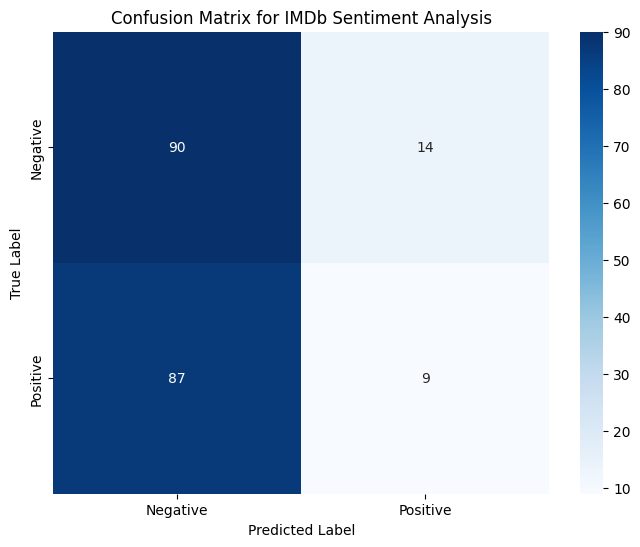


Confusion Matrix:
True Positives (TP): 9
True Negatives (TN): 90
False Positives (FP): 14
False Negatives (FN): 87

Metrics for 'Positive' class:
Precision: 0.39
Recall: 0.09
F1-Score: 0.15


In [ ]:
# Extract the predicted labels from the model output.
# The `predictions.predictions` contains the logits, and `argmax` gives the predicted class index.
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test dataset.
true_labels = np.array(tokenized_test_subset["label"])

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names for a better visual representation
class_names = ["Negative", "Positive"]

# --- 5. Visualize the Confusion Matrix ---
print("Visualizing the confusion matrix...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for IMDb Sentiment Analysis')
plt.show()

# Print the confusion matrix values for clarity
print("\nConfusion Matrix:")
print(f"True Positives (TP): {cm[1, 1]}")
print(f"True Negatives (TN): {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")

# You can also calculate precision, recall, and F1-score from this matrix.
# For example, for the 'Positive' class (label 1):
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMetrics for 'Positive' class:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

In [ ]:
train_subset = dataset["train"].shuffle(seed=42).select(range(100))
tokenized_train_subset = train_subset.map(tokenize_function, batched=True)
tokenized_train_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,  # A single epoch for demonstration.
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_subset,
)

trainer.train()

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=13, training_loss=0.715912965627817, metrics={'train_runtime': 688.2089, 'train_samples_per_second': 0.145, 'train_steps_per_second': 0.019, 'total_flos': 26311105536000.0, 'train_loss': 0.715912965627817, 'epoch': 1.0})

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Visualizing the confusion matrix...


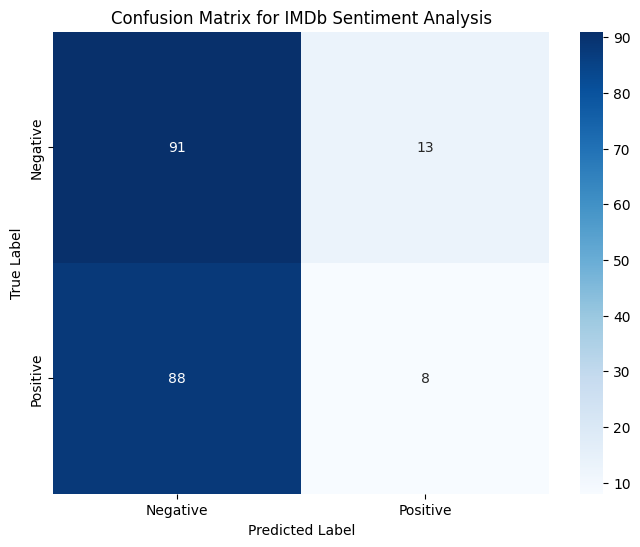


Confusion Matrix:
True Positives (TP): 8
True Negatives (TN): 91
False Positives (FP): 13
False Negatives (FN): 88

Metrics for 'Positive' class:
Precision: 0.38
Recall: 0.08
F1-Score: 0.14


In [ ]:
with torch.no_grad():
    # Make predictions on the test dataset
    predictions = trainer.predict(tokenized_test_subset)

# Extract the predicted labels from the model output.
# The `predictions.predictions` contains the logits, and `argmax` gives the predicted class index.
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test dataset.
true_labels = np.array(tokenized_test_subset["label"])

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names for a better visual representation
class_names = ["Negative", "Positive"]

# --- 5. Visualize the Confusion Matrix ---
print("Visualizing the confusion matrix...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for IMDb Sentiment Analysis')
plt.show()

# Print the confusion matrix values for clarity
print("\nConfusion Matrix:")
print(f"True Positives (TP): {cm[1, 1]}")
print(f"True Negatives (TN): {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")

# You can also calculate precision, recall, and F1-score from this matrix.
# For example, for the 'Positive' class (label 1):
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMetrics for 'Positive' class:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")